<a href="https://colab.research.google.com/github/evanshlom/pyspark_ml_web_app/blob/main/PySpark_ML_Hackathon_Sprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

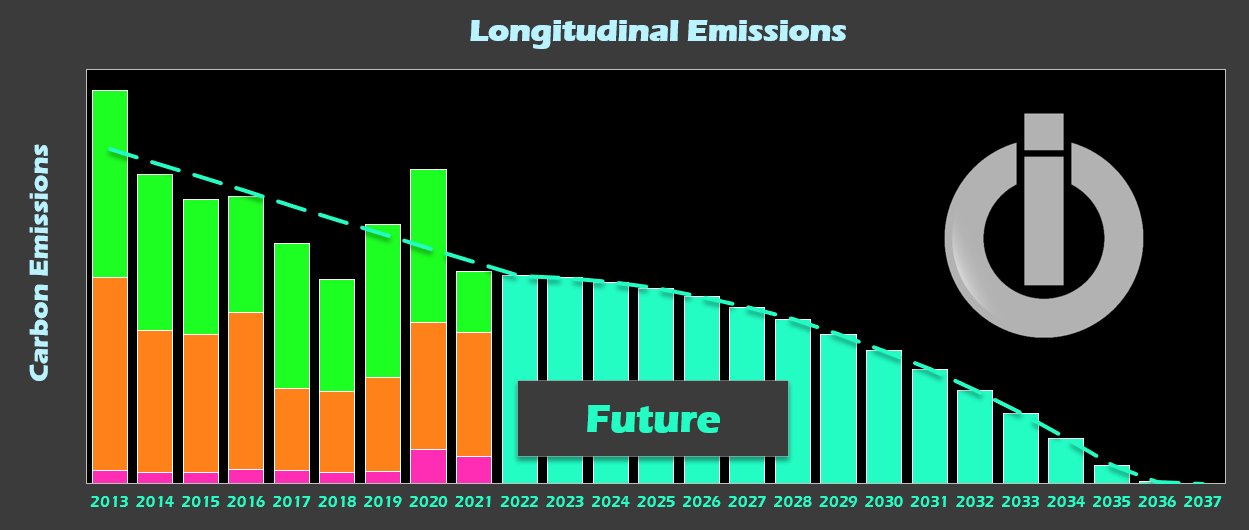

# train.py

In [ ]:
#@title Welcome to the hackathon sunday sprint:

#@markdown MACHINE LEARNING W/ PYSPARK & 

#@markdown Table Of Contents:

#@markdown 1.)  LOAD: Load anonymous dataset (values were randomized for privacy)

#@markdown 2.)  PREPARE: Preprocess dataset

#@markdown 3.)  MODEL: Train and Test Regressor

#@markdown 4.)  SAVE: Pickle model

#@markdown Please contact Evan Shlom with any feedback or questions at eshlom@fandm.edu or via the LinkedIn page for Innovative Operations at https://www.linkedin.com/company/innovativeoperations/

#Filename = None #@param {type:"raw"}
#Filepath = None #@param {type:"raw"}

#@title

from google.colab import files
uploaded = files.upload()

#print(raw_input)
#print(raw_input2)

Saving sustainability.csv to sustainability.csv


Import File

***NEED TO EDIT THE PIPELINE FOR NET ZERO TEMPLATE 0.3.0 INSTEAD OF VXN 0.2.0

In [ ]:
#1
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 41.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=1570a198049c8a8e8a9bfe3a11c06f905812183056c270fa6fa73b785c95e8f6
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
#2
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("PySpark Deployed Machine Learning with Unit Testing")\
        .master("local[*]")\
        .getOrCreate()

In [ ]:
import io
# rdd used to ingest data
# df could span entire pipeline
rdd = spark.read.csv("sustainability.csv", header=True).rdd

In [ ]:
# Persist RDD --- run unit test with these two persist methods as separate user-defined functions in a class, and unit test base as other class, with actual unit test in a third class with the two unit test functions
from pyspark.storagelevel import StorageLevel

# persist serialized
rdd_unserialize = rdd
rdd_unserialize.persist(StorageLevel.MEMORY_AND_DISK)

MapPartitionsRDD[14] at javaToPython at NativeMethodAccessorImpl.java:0

In [ ]:
# inspect number of rows per institution_name
# throwaway
rdd.countByKey().items()

dict_items([('a', 6), ('b', 11), ('c', 9), ('d', 14), ('e', 8), ('f', 13), ('g', 10), ('h', 14), ('i', 15), ('j', 18), ('k', 16), ('l', 9), ('m', 17), ('n', 9), ('o', 15), ('p', 8), ('q', 16), ('r', 6), ('s', 9), ('t', 14), ('u', 18), ('v', 7)])

In [ ]:
# inspect first row of data in rdd
# throwaway
rdd.first()

Row(institution_name='a', Fiscal Year='2017', timestep='15', reverse_timestep='4', EUI-Adjusted Floor Space='248,942', gsf='248942', Weighted Campus User='416', fte_per_gsf='0.00167', Maintained Acres='0', Total Enrollment (FTE)2='298', Faculty (FTE)3='90', Staff (FTE)4='68', E-Grid Pre-2006='WECC California', E-Grid='WECC California', Scope 1 Emissions='840.0128467', Scope 2 Emissions='429.2013956', Scope 3 Emissions='555.3030901', Gross Emissions='1824.517332', Net Emissions='1,824.52', net_mtcde_per_gsf='0.00733', Stationary Emissions='584.2693621', Fleet Emissions='255.6980763', Refrigerant Emissions='0', Agricultural Emissions='0.045408263', Purchased Electric Emissions='429.2013956', Purchased Steam Emissions='0', Purchased Chilled Water Emissions='0', Student Community Emissions='13.6495915', Employee Commuting Emissions='106.1943118', Other Travel Emissions='141.8034551', Waste Emissions='258.94792', Wasterwater  Emissions='5.095961665', Paper Emissions='10.6547454', T&D Losses

In [ ]:
# convert rdd to df
# df for preprocessing
df = rdd.toDF()

# change type to float or int for feature and output cols
from pyspark.sql.types import DecimalType, IntegerType
decimal = DecimalType(precision=20, scale=5)
df = df \
      .withColumn("timestep",
                  df["timestep"]
                  .cast(IntegerType()))     \
      .withColumn("fte_per_gsf",
                   df["fte_per_gsf"]
                   .cast(decimal))    \
      .withColumn("net_mtcde_per_gsf",
                   df["net_mtcde_per_gsf"]
                   .cast(decimal))

df.printSchema()
df.show(truncate=False)

root
 |-- institution_name: string (nullable = true)
 |-- Fiscal Year: string (nullable = true)
 |-- timestep: integer (nullable = true)
 |-- reverse_timestep: string (nullable = true)
 |-- EUI-Adjusted Floor Space: string (nullable = true)
 |-- gsf: string (nullable = true)
 |-- Weighted Campus User: string (nullable = true)
 |-- fte_per_gsf: decimal(20,5) (nullable = true)
 |-- Maintained Acres: string (nullable = true)
 |-- Total Enrollment (FTE)2: string (nullable = true)
 |-- Faculty (FTE)3: string (nullable = true)
 |-- Staff (FTE)4: string (nullable = true)
 |-- E-Grid Pre-2006: string (nullable = true)
 |-- E-Grid: string (nullable = true)
 |-- Scope 1 Emissions: string (nullable = true)
 |-- Scope 2 Emissions: string (nullable = true)
 |-- Scope 3 Emissions: string (nullable = true)
 |-- Gross Emissions: string (nullable = true)
 |-- Net Emissions: string (nullable = true)
 |-- net_mtcde_per_gsf: decimal(20,5) (nullable = true)
 |-- Stationary Emissions: string (nullable = tru

In [ ]:
# throwaway - ignore this kernel
# Define features
feature_cols = [
            "timestep",
            "fte_per_gsf"
]          
X = df.select(feature_cols)
# Define target
y = df.select("net_mtcde_per_gsf")

In [ ]:
# import VectorAssembler
from pyspark.ml.feature import VectorAssembler
# get feature vectors
feature_cols = [
            "timestep",
            "fte_per_gsf"
]
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="feature_vector")
# new vector col for x_train: "feature_vector" 
df = assembler.transform(df)
df.show()

+----------------+-----------+--------+----------------+------------------------+------+--------------------+-----------+----------------+-----------------------+--------------+------------+---------------+--------------------+-----------------+-----------------+-----------------+---------------+-------------+-----------------+--------------------+---------------+---------------------+----------------------+----------------------------+-------------------------+---------------------------------+---------------------------+----------------------------+----------------------+---------------+----------------------+---------------+--------------------+----------------+-----------------+---------+---------+-------+-----+------+--------------+
|institution_name|Fiscal Year|timestep|reverse_timestep|EUI-Adjusted Floor Space|   gsf|Weighted Campus User|fte_per_gsf|Maintained Acres|Total Enrollment (FTE)2|Faculty (FTE)3|Staff (FTE)4|E-Grid Pre-2006|              E-Grid|Scope 1 Emissions|Scope 2

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed=0)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 186
Test Dataset Count: 76


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="feature_vector",
                           labelCol="net_mtcde_per_gsf",
                           maxDepth=5,
                           maxBins=1000)
rf.setSeed(0)
rfModel = rf.fit(train)

In [ ]:
# infer output for test vectors
# automatically add inferences col "prediction" to test df
predictions_test = rfModel.transform(test)

predictions_test.select("feature_vector", "net_mtcde_per_gsf", "prediction").show(25)

#calc mean squared error and evaluate, consider cross val, k fold val

+--------------+-----------------+--------------------+
|feature_vector|net_mtcde_per_gsf|          prediction|
+--------------+-----------------+--------------------+
|[14.0,0.00167]|          0.00644|0.007891433872905432|
|[18.0,0.00173]|          0.00601|0.007549695851077...|
|[10.0,0.00113]|          0.00511|0.007064230483022611|
|[14.0,0.00655]|          0.01606|0.023200471346015095|
|[15.0,0.00644]|          0.01342|0.021103293240093236|
| [4.0,0.00397]|          0.01773| 0.01738335622412008|
| [5.0,0.00451]|          0.01497|0.016992710808270677|
| [6.0,0.00443]|          0.01449|0.014311072196342303|
| [9.0,0.00432]|          0.01354| 0.01138694609310614|
|[12.0,0.00473]|          0.01095|0.015451013374911022|
|[13.0,0.00539]|          0.01101| 0.01600861586408851|
|[15.0,0.00508]|          0.00967|0.015927005465597478|
|[10.0,0.00248]|          0.00976|0.010507178241045039|
|  [8.0,0.0056]|          0.01409|0.013740696931869304|
| [9.0,0.00556]|          0.01389|0.013213568143

In [ ]:
# train model to be saved for app, training using all data (wouldnt do it this way if I wasnt in a rush making a starter prototype)
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="feature_vector",
                           labelCol="net_mtcde_per_gsf",
                           maxDepth=5,
                           maxBins=1000)
rf.setSeed(0)
rfModel = rf.fit(df)

In [ ]:
# use this in app to return outputs to user, using user's data
predictions = rfModel.transform(test)

In [ ]:
from google.colab import drive
drive.mount('/content/')
#drive.mount('/content/drive/')

ValueError: ignored

In [ ]:
# save model to path - debug 
rfModel.write().overwrite().save("/content/inference_rfmodel")
#rf.save("/content/drive/My Drive/x/rfModel")

In [ ]:
# save model using Joblib - debug
from joblib import dump
dump(rfModel, 'Inference_rfModel.joblib')

# inference.py

In [ ]:
from google.colab import files
uploaded_inf = files.upload()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("PySpark Deployed Machine Learning with Unit Testing")\
        .master("local[*]")\
        .getOrCreate()

In [ ]:
rdd = spark.read.csv("sustainability_inference.csv", header=True).rdd

In [ ]:
# Persist RDD --- run unit test with these two persist methods as separate user-defined functions in a class, and unit test base as other class, with actual unit test in a third class with the two unit test functions
from pyspark.storagelevel import StorageLevel

# persist without serialization
rdd_serialize = rdd
rdd_serialize.persist(StorageLevel.DISK_ONLY)
####!!!! add unittest1 around this
rdd_serialize.unpersist()

# persist serialized
rdd_unserialize = rdd
rdd_unserialize.persist(StorageLevel.MEMORY_AND_DISK)
####!!!!! add unittest2 around this
rdd_unserialize.unpersist()

In [ ]:
# convert rdd to df
# df for preprocessing
df = rdd.toDF()

# change type to float or int for feature and output cols
from pyspark.sql.types import DecimalType, IntegerType
decimal = DecimalType(precision=20, scale=5)
df = df \
      .withColumn("timestep",
                  df["timestep"]
                  .cast(IntegerType()))     \
      .withColumn("fte_per_gsf",
                   df["fte_per_gsf"]
                   .cast(decimal))    \
      .withColumn("net_mtcde_per_gsf",
                   df["net_mtcde_per_gsf"]
                   .cast(decimal))

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
            "timestep",
            "fte_per_gsf"
]
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol="feature_vector")
df = assembler.transform(df)
df.show()

In [ ]:
# load saved model file
from joblib import load
rfModel_loaded = load("/content/Inference_rfModel.joblib")

In [ ]:
# load saved model file
import joblib
joblib.load("/content/Inference_rfModel.joblib")

In [ ]:
predictions_test = rfModel.transform(test)

predictions_test.select("feature_vector", "net_mtcde_per_gsf", "prediction").show(25)

In [ ]:
from pyspark.mllib.feature import StandardScaler
standardizer = StandardScaler(True, True)
X = standardizer.fit(X).transform(X)

In [ ]:
output.show()

In [ ]:
from pyspark.ml.regression import LinearRegression
reg = LinearRegression()
model = reg.fit(df)
model.setFeaturesCol("X")
model.setPredictionCol("y")


In [ ]:
# select rdd X so X can be standardized
# X is an rdd

rdd.collect(
    "timestep",
    "fte_per_gsf"
)

#X = 

In [ ]:
from pyspark.mllib.feature import StandardScaler
standardizer = StandardScaler(True, True)
X = standardizer.fit_transform(X)

In [ ]:
rdd = rdd.na.drop()
rdd.count()

In [ ]:
rdd.show(10)

In [ ]:
X = rdd.fiter(feature_cols)

In [ ]:
#3
from pyspark.sql import DataFrameReader
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType

# lazy evaluation
# user-defined schema to optimize Spark by causing less jobs to run ("inferSchema would cause 2nd job to run)
# False means that the schema rejects null values (those samples are rejected from the DataFrame)
csvSchema = StructType([StructField("institution_name", StringType(), True)],
                       [StructField("timestep", IntegerType(), True)],
                       [StructField("fte_per_gsf", DecimalType(precision=20,scale=5), True)],
                       [StructField("net_mtcde_per_gsf", DecimalType(precision=20,scale=5), True)],
                       [StructField("gsf", DecimalType(precision=20,scale=5), True)])

df = DataFrameReader.format("csv").schema(csvSchema).load(io.BytesIO(uploaded))

In [ ]:
#3
from pyspark.sql import DataFrameReader
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DecimalType

# lazy evaluation
# user-defined schema to optimize Spark by causing less jobs to run ("inferSchema would cause 2nd job to run)
# False means that the schema rejects null values (those samples are rejected from the DataFrame)
csvSchema = StructType([StructField("institution_name", StringType(), False)],
                       [StructField("timestep", IntegerType(), False)],
                       [StructField("fte_per_gsf", DecimalType(precision=20,scale=5), False)],
                       [StructField("net_mtcde_per_gsf", DecimalType(precision=20,scale=5), False)],
                       [StructField("gsf", DecimalType(precision=20,scale=5), False)])

df = DataFrameReader.format("csv").schema(csvSchema).load(io.BytesIO(uploaded))

In [ ]:
import pandas as pd
import io

filename = next(iter(uploaded))

#(..., index_col='id')
dataset = pd.read_csv(io.BytesIO(uploaded['{}'.format(filename)]), skiprows=0)

df = dataset[['institution_name', 'timestep', 'fte_per_gsf', 'net_mtcde_per_gsf', 'gsf']].astype({
    'institution_name' : 'str',
    'timestep' : 'int',
    'fte_per_gsf' : 'float',
    'net_mtcde_per_gsf' : 'float',
    'gsf' : 'float'
})

In [ ]:
df = df.astype({
    
})

In [ ]:
display(df)

In [ ]:
# Define features
feature_cols = [
            'timestep',
            'fte_per_gsf'
]          
X = df[feature_cols]
# Define target
y = df.net_mtcde_per_gsf

In [ ]:
from sklearn.linear_model import LinearRegression

# Define Model
reg = LinearRegression()

reg.fit(X, y)

In [ ]:
from joblib import dump
dump(reg, 'Inference_reg.joblib')

# inference.py

In [ ]:
from google.colab import files
uploaded_inf = files.upload()

In [ ]:
filename_inf = next(iter(uploaded_inf))

#(..., index_col='id')
dataset_inf = pd.read_csv(io.BytesIO(uploaded_inf['{}'.format(filename_inf)]), skiprows=0)

df_inf = dataset_inf[['timestep', 'fte_per_gsf', 'net_mtcde_per_gsf', 'gsf']].astype({
    'timestep' : 'int',
    'fte_per_gsf' : 'float',
    'net_mtcde_per_gsf' : 'float',
    'gsf' : 'float'
})

In [ ]:
# Define features
feature_cols = [
            'timestep',
            'fte_per_gsf'
]          
X_inf = df_inf[feature_cols]
# Define target
y_inf = df_inf.net_mtcde_per_gsf

In [ ]:
from joblib import load
lin_reg = load('Inference_reg.joblib')

In [ ]:
print("Lin reg prediction:")

inference = lin_reg.predict(X_inf)
print(inference)

# de-normalize y inference to get total mtcde
# multiply (mtcde/gsf) by gsf
inf_total = inference * df_inf.gsf

print(inf_total)

In [ ]:
#add dataframe with fiscal year 2002 to 2049
#band-aiding right now by making it a dataframe with fiscal year 2013 to 2049 for this inference only
fy_inf = []
i = 2013
while len(fy_inf) < 37:
  fy_inf.append(i)
  i += 1

In [ ]:
dict_inf = {
    'Fiscal Year' : fy_inf,
    'Prediction' : inf_total
}

df_client = pd.DataFrame(dict_inf)
df_client

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
## Scale features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)

# Read the data
X_full = df
X_test_full = test_df

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Define features
feature_cols = [
            'timestep',
            'fte_per_gsf'
]          
X = df[feature_cols]
# Define target
y = df.net_mtcde_per_gsf

# Keep selected columns only
X_train = X_train_full[feature_cols].copy()
X_valid = X_valid_full[feature_cols].copy()
X_test = X_test_full[feature_cols].copy()

In [ ]:
X_train.head()

In [ ]:
from sklearn.linear_model import LinearRegression

# Define Model
model = LinearRegression()
#try ridge/lasso/elasticnet

model.fit(X_train, y_train)

In [ ]:
#
!pip install pyspark
#

In [ ]:
#https://stackoverflow.com/questions/56426069/how-to-read-xlsx-or-xls-files-as-spark-dataframe

#spark = SparkSession.builder \
#.master("local") \
#.appName("Net Zero") \
#.config("spark.jars.packages", "com.crealytics:spark-excel_2.11:0.12.2") \
#.getOrCreate()

#df = spark.read.format("com.crealytics.spark.excel") \
#.option("useHeader", "true") \
#.option("inferSchema", "true") \
#.option("dataAddress", "'NameOfYourExcelSheet'!A1") \
#.load("your_file"))

In [ ]:
!pip install findspark

In [ ]:
import pandas as pd
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext 
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

read = pd.read_excel(io.BytesIO(uploaded['{}'.format(filename)]),sheet_name=['{}'.format('1 _ Template - Only Historical')], skiprows=0)
df = read['1 _ Template - Only Historical']

df = sql.createDataFrame(df)

df.show()

sc

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['fy',
                                         'fte',
                                         'enrollment_change',
                                         'gsf'],
                            outputCol = 'features')
df2 = assembler.transform(df)
df3 = df2.select('features', 'total_s')

df3.show()

In [ ]:
train_data, test_data = df3.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features',
                      labelCol = 'total_s')

model = lr.fit(train_data)

im not sure how the model's "evaluate" method works...need to understand how it's allowing for r2 to be calulcated after only taking train_data as argument 

In [ ]:
results = model.evaluate(train_data)
print('RSquaredError :', results.r2)

Test Predictions

In [ ]:
unlabeled_data = test_data.select('features')
unlabeled_data.show()

predictions = model.transform(unlabeled_data)
predictions.show()

In [ ]:
#prepare prediction set for Pathway To Zero:
#final_train = ... :


##reminder about code from top of program... :
##df_emissions_future = mtcde_future['3 _ Template - Only Future']



read_future = pd.read_excel(io.BytesIO(uploaded['{}'.format(filename)]),sheet_name=['{}'.format('3 _ Template - Only Future')], skiprows=0)
df_future = read['1 _ Template - Only Historical']

df_future = sql.createDataFrame(df_future)

df_future.show()


In [ ]:
#PySpark
######## USE THIS INSTEAD, IF I CAN FIGURE OUT HOW TO READ EXCEL TABLE INTO PYSPARK DATAFRAME WITHOUT USING PANDAS AS MIDDLEMAN IN PIPELINE AS I PROGRAMMED ABOVE THIS KERNEL 


#from pyspark.sql import SparkSession



#spark = SparkSession.builder.appName('Net_Zero_Predictor').getOrCreate()

#df = spark.read.format(io.BytesIO(uploaded['{}'.format(filename)]),sheet_name=['{}'.format('1 _ Template - Only Historical')],\
                    skiprows=0, inferSchema=True, header=True)

#df.show

In [ ]:
display(df_emissions_history.head())
display(df_emissions_full.head())
display(df_emissions_future.head())

Fit Model to Predict Total Emissions from FY (draft for figuring out syntax before further editing the real model in the kernels below this)

In [ ]:
X = df_emissions_history.fy
y = df_emissions_history.total_s
#will need to change total_s to total.

#from sklearn.linear_model import LinearRegression as reg

from sklearn import linear_model

reg = linear_model.LinearRegression()

reg.fit(df_emissions_history[['fy']], y)

print(reg.coef_)
print(reg.intercept_)

In [ ]:
reg.predict([[2022]])

Fit Model to predict Total Emissions from FY & Enrollment & GSF

In [ ]:
X = df_emissions_history.fy
y = df_emissions_history.total_s
#will need to change total_s to total.

#from sklearn.linear_model import LinearRegression as reg

from sklearn import linear_model

reg = linear_model.LinearRegression()

reg.fit(df_emissions_history[['fy','enrollment_change','gsf']], y)

print(reg.coef_)
print(reg.intercept_)

In [ ]:
print( reg.predict([[2013,-0.017,302010]]) )
print( reg.predict([[2014,-0.049,302010]]) )
print( reg.predict([[2015,-0.062,302010]]) )
print( reg.predict([[2016,-0.019,302010]]) )
print( reg.predict([[2017,-0.016,302010]]) )
print( reg.predict([[2018,0.030,302010]]) )
print( reg.predict([[2019,-0.065,351388]]) )
print( reg.predict([[2020,0.000,351388]]) )
print( reg.predict([[2021,0.042,333702]]) )
print( reg.predict([[2022,-0.005,333702]]) )
print( reg.predict([[2023,0.015,333702]]) )
print( reg.predict([[2024,-0.005,333702]]) )
print( reg.predict([[2025,0.030,333702]]) )
print( reg.predict([[2026,-0.020,333702]]) )
print( reg.predict([[2027,-0.035,333702]]) )
print( reg.predict([[2028,-0.025,333702]]) )
print( reg.predict([[2029,-0.020,333702]]) )
print( reg.predict([[2030,-0.010,333702]]) )
print( reg.predict([[2031,0.040,333702]]) )
print( reg.predict([[2032,0.015,333702]]) )
print( reg.predict([[2033,-0.025,333702]]) )
print( reg.predict([[2034,-0.010,333702]]) )
print( reg.predict([[2035,-0.010,333702]]) )
print( reg.predict([[2036,-0.010,333702]]) )
print( reg.predict([[2037,-0.010,333702]]) )

#reg.predict([[2027,-0.035,333702]])
#reg.predict([[2031,0.040,333702]])

In [ ]:
future_fy = [2022,
             2023,
             2024,
             2025,
             2026,
             2027,
             2028,
             2029,
             2030,
             2031,
             2032,
             2033,
             2034,
             2035,
             2036,
             2037]

future_fy = future_fy.reshape(length, 1)

future_total_lob = reg.predict(future_fy)
future_total_lob

In [ ]:
X = df_emissions_history[['1_s', '2_s', '3_s']]
y = df_emissions_history[['total_lob']]

In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
model = regr.fit(X, y)

In [ ]:
print('Intercept: \n', regr.intercept_)
print('Coefficients of Historical Emissions By Scope to Historical Line Of Best Fit \n', regr.coef_)

In [ ]:
#101, 201, 301 = df_emissions_future[['1_s', '2_s', '3_s']]


In [ ]:
#PREDICT

X_pred = [452,
     1452,
     1609]

#not sure if will return all or just one predicction.... can prby code it either way but depends on my coding approach...for now is hould stick to simplest barebones and bruteforce it!
prediction = model.predict(X_pred)
prediction_num = float(prediction)
prediction_num_formatted_commas = "{:,}".format(prediction_num)

[TOGGLED OFF] Select Dataset

In [ ]:
#@title
#Get only needed features from projects tab
#df = entire_df[['ID', 'Fiscal Year', 'Project Name', 'Actual Spent', 'Package']]#set df for all necessary columns, this df to be split into a training set and testing set
#!!#df

Prepare Dataset for Model

In [ ]:
#@title
df['Generated'] = 'Unknown'#Program will output 'Unknown' for obscure project names 
df['Explanation'] = ''#Program will provide learning opportunity using the relevant keyword in project name
df.rename(columns = {'Project Name':'Name'}, inplace = True) 
#!!#df

Avoid Error

In [ ]:
#@title
# Remove settingwithcopywarning from pandas 
pd.options.mode.chained_assignment = None  # default='warn'

Scrub Data

In [ ]:
#@title
df.Name = df.Name.astype(str)
#!!#print(type(df.Name[88]))
#!!#df.Name

[KERNEL RUNS BUT DF.REPLACE DIDNT WORK] Handle Special Characters

In [ ]:
#@title
#Create Dictionary
#dict = {look in this column: {find this value: replace with this value}}
dict = {
    'Name': {'\!': ' '},
    'Name': {'\@': ' '},
    'Name': {'\#': ' '},
    'Name': {'\$': ' '},
    'Name': {'\%': ' '},
    'Name': {'\^': ' '},
    'Name': {'\&': ' '},
    'Name': {'\*': ' '},
    'Name': {'\(': ' '},
    'Name': {'\)': ' '},
    'Name': {'\-': ' '},
    'Name': {'\_': ' '},
    'Name': {'\=': ' '},
    'Name': {'\+': ' '},
    'Name': {'\[': ' '},
    'Name': {'\{': ' '},
    'Name': {'\]': ' '},
    'Name': {'\}': ' '},
    'Name': {'\;': ' '},
    'Name': {'\:': ' '},
    'Name': {"\'": ' '},
    'Name': {'\"': ' '},
    'Name': {'\,': ' '},
    'Name': {'\<': ' '},
    'Name': {'\.': ' '},
    'Name': {'\>': ' '},
    'Name': {'\/': ' '},
    'Name': {'\?': ' '} 
}


#Replace
df.replace(dict, regex=True, inplace=True)

Define Packages

In [ ]:
#@title
# Define terms for each package

# excluding terms for: 'renov' 'rnvntn' 'renvtn'

# terms that could benefit from generalization across projects: 'relocation', 'lighting' ...

Envelope_terms = [
    'architectural',
    'awning',
    'balcony',
    'brick',
    'bldg envel',
    'entrance way',#keep an eye on this
    'envelop',
    'exterior',
    'external',
    'facade',
    'Façade',
    'front entr',
    'dumpster',
    'gutter',
    'lettering',
    'main entr',
    'masonr',
    'ramp',
    'roof',
    'paint exterior'#comes after 'Generate' Space_Renewal_terms search for 'paint'
    'patio',
    'pointed',
    'pointing',
    'porch',
    'shingle',
    'shutter',
    'sky light',
    'skylight',
    'walk off mat',
    'walkoff mat',
    'window'
]

Space_Renewal_terms = [
    'attic',
    'beverage',
    'bed',
    'carpet',
    'ceiling',#also covers 'ceiling fan'
    'chair',
    'climb wall',
    'climbing wall',
    'damage',
    'reconfiguration',
    'rug',
    'room',
    'floor chemical',
    'floor polish',
    'floor wax',
    'flooring',
    'furn',#gets overriden by 'furnace' in Building_Systems_override_terms
    'tile',
    'hallway',
    'indoor',#keeping other indoor terms for now, because might need to remove 'indoor' if it doesnt continue to test well
    'indoor basketball',
    'indoor softball',
    'indoor tennis',
    'interior',
    'kitchen vinyl',
    'lab fit',
    ' level stairs',
    'locker',
    'mirror',
    'noise remov',
    'office',
    'partition',
    'receptacl',
    'remodel',
    'renovation repair',
    'res door'
    ' rm ',
    'rolling curtain',
    'paint',
    'space renewal',
    'stair well',
    'stairwell',
    'suite upgr',
    'wallpaper'
]

Building_Systems_terms = [
    ' ac '
    'ac out',
    'ac repl',
    'ac upgr',
    'aerator',
    ' ahu',
    'air condi',
    'air cycl',
    'air duct',
    'air handl',
    'air mix',
    'air qual',
    'boiler',
    'building system',
    'chille',
    'coils',
    'cold storage',
    'compress',
    'conduit',
    'controller',
    'control sys',
    'control upgr',
    'controls sys',
    'controls upgr',
    'cooling',
    'dehumidification',
    'dining hood',
    'electric feeder',
    'electric outlet',
    'electrical feeder',
    'electrical outlet',
    'elevator',
    ' erv ',
    'equipment conn',
    'exhaust',
    'distribution',
    'duct repl',
    'fan coil',
    'fume hood',
    'generator',
    'kitchen hood',
    'hvac',
    'high volt',
    'hot water',
    'humidity',
    'hydraul',
    ' led ',
    'light bulb',
    'lightbulb',
    'mechanical',
    'panel',
    'piping',
    'plumbing',
    'pool light',
    'powerfeed',
    'propane',
    'pump',#keep an eye on this
    ' rau ',
    'reinsulate',
    'repl ac ',
    'replace ac ',
    'rtu ',
    'split system',
    'steam stack',
    'steel bracing',
    'switchgear',
    'systems',
    'system upgr',
    'tank',
    'toilet renov',
    'transformer',
    'unit repl',
    'unit upgr',
    'variable frequency drive',
    'ventilat',
    'vfd',
    'volt power',
    'wire',
    'water fountain',
    'water heater',
    'water repairs'
]

Grounds_Infrastructure_terms = [
    'arboretum',
    'asphalt',
    'bicycl',
    'biker',
    'biking',
    'bollard',
    'bus shelter',
    'campus bridge',
    'campus sign',
    'campus fenc',
    'campus rock',
    'campus wide sign',
    'campus-wide sign',
    ' drive ',
    ' field',
    'grass',
    'graveyard',
    'grounds',
    'intersection',
    'irrigat',
    'landscap',
    'lot',
    'manhole',
    'outdoor signag',
    'park',
    'parking lot',
    'paving',
    'pedestrian',
    'playground',
    'pot hole',
    'pothole',
    'promenade',
    ' pond ',
    'retaining wal',
    'roadway',
    'road repair',
    'salt shed',
    'sidewalk',
    'statue',
    'tennis court',
    'track perim',
    'track upgr',
    'trail',
    'trees',
    'turf'
]

Utility_Infrastructure_terms = [
    'campus distribution',
    'campus elec',
    'campus fossil',
    'campus gas',
    'campus power',
    'campus sub',#sub-metering
    'campus util',
    'gas pump',
    'gas line',
    'geotherm',
    'pipes',
    'piping',
    'sewer pip',
    'sewer sys',
    'steam line',
    'substation',
    'sub meter b',
    'sub metering b',
    'sub-meter b',
    'sub-metering b',
    'submeter b',
    'submetering b',
    'tele infra',
    'utility & infra',
    'utility and infra',
    'utility meter',
    'utility infra',
    'utilities infra',
    'utilities meter',
    'water line',
    'waterline'
]

Non_Facilities_terms = [
    'covid',
    'automatic scrubber',
    'abatement',
    'analysis',
    'assessment',
    'audio/visual',
    'audiovisual',
    ' car ',
    ' cars',
    'charge',
    'computer equip',
    'computers',
    'computing prog',
    'consulting',
    'design',
    'dining equip',
    'fiber optic',
    'fiberoptic',
    'imaging',
    'it equip',
    'demolition',
    'feasibility',
    'guideline',
    'internet',
    'it for ',
    'kitchen equip',
    'leaf vaccum'
    'master plan',
    'media equip',
    'network',
    'non-facilit',
    'non facilit',
    'nonfacilit',
    'planning',
    'procure',
    ' programming',
    'provost',
    'software',
    'study',
    'survey',
    'tech update',
    ' tva ',
    'unallocated',
    'vehicle',
    'wireless',
    'wifi'
]

Safety_Code_terms = [
    'access control',
    ' ada ',
    'asbestos',
    'building access',
    'bldg access',
    'fire ',
    'handicap elevator',
    'handicap ramp',
    'handicap lift',
    'handrail',
    'sprinklers',
    'alarm',
    'lock ',
    'locksmith',
    'railroad crossing',
    'wheelchair',
    'wheelchair elevator',
    'wheelchair lift',
    'wheelchair ramp',
    'handicap',
    'safety',
    'security',
    'sprinkler',
    'emergency',
    'bluelight',
    'blue light'
]

New_Space_terms = [
    'building addition',
    'bldg addition',
    'expansion',
    'new addition',
    'new apartment',
    'new space',
    'new construction',
    'new building',
    'new chapter house',
    'new dining hall',
    'new floor',
    'new fraternity house',
    'new house',
    'new residence hall',
    'new room',
    'site dev'
]

Mixed_terms = [
    'Renovation and Addition',
    'Renovation & Addition',
    'Renovations and Additions',
    'Renovations & Additions'
]

#!!#print(Space_Renewal_terms)
#!!#print(Building_Systems_terms)
#!!#print(Envelope_terms)
#!!#print(Safety_Code_terms)
#!!#print(Grounds_Infrastructure_terms)
#!!#print(Utility_Infrastructure_terms)
#!!#print(New_Space_terms)
#!!#print(Non_Facilities_terms)

Package Projects

In [ ]:
##@title
# GENERATE PACKAGES

##!##it would clean this code to set a new default argument for the str.contains() parameter *case=False* (by default it is set to True)
##!##https://stackoverflow.com/questions/25126805/change-default-arguments-of-function-in-python

#df.loc[df['Name'].str.contains(r'(?:{})'.format('|'.join(Space_Renewal_terms)))]
#df.loc[df['Name'].str.contains(r'(?:{})'.format('|'.join(Envelope_terms)))]

# search project names and generate package codings in df col 'Generate' for envelope projects:


# Generate Grounds Infrastructure:
# Generate Grounds Infrastructure first, because its terms tend to show up in other project names that do not involve any grounds infrastructure work (ie "Field House" includes term 'field') 
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Grounds_Infrastructure_terms)), case=False), 'Generated'] = 'Grounds Infrastructure'

# Generate Utility Infrastructure:
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Utility_Infrastructure_terms)), case=False), 'Generated'] = 'Utility Infrastructure'

# Generate Building Systems:
# Generate Building Systems AFTER Utility Infrastructure, because 'substation' is a Utility Infrastructure term but sometimes a substation project will be for a 'chiller' or 'cooling tower' ...
#   which would more likely be a Building Systems project
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Building_Systems_terms)), case=False), 'Generated'] = 'Building Systems'

# Generate Space Renewal:
# (( for Space_Renewal_override_terms: the Envelope term 'roof' would otherwise re-generate for projects with the term 'soundproof' and 'sound proof'))
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Space_Renewal_terms)), case=False), 'Generated'] = 'Space Renewal'

# Generate Envelope:
# Generate Envelope AFTER Space Renewal, because 'exterior' painting would otherwise get overriden by 'paint' which is a Space Renewal term
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Envelope_terms)), case=False), 'Generated'] = 'Envelope'

# Generate Safety/Code:
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Safety_Code_terms)), case=False), 'Generated'] = 'Safety/Code'

# Generate Non-Facilities:
# Generate Non-Facilities third-last (last except for New Space and Mixed), because 'design', 'study', 'plan ' need to override some projects
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Non_Facilities_terms)), case=False), 'Generated'] = 'Non-Facilities'

# Generate New Space:
# Generate New Space second-last, because other terms need to be replaced to New Space if the project involves new space (New Space beats other package codings, except Mixed)
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(New_Space_terms)), case=False), 'Generated'] = 'New Space'

# Generate Mixed:
# Generate Mixed dead-last, because the few Mixed terms should replace other package codings if the Mixed terms are used in a project name (similar to New Space, but beats New Space)
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Mixed_terms)), case=False), 'Generated'] = 'Mixed'

Define Package Overrides

In [ ]:
#@title
# list override terms for each package too, which would solve a lot of temporary solutions, with solutions that can effectively be permanent !!! ie generate those after generating the initial package term generations

Space_Renewal_override_terms = [
    'sound proof',
    'soundproof'
]

Building_Systems_override_terms = [
    ' ac repl',
    'emergency generator',#overrides Safety/Code term 'emergency'
    'expansion tank',#overrides New Space term 'expansion'
    'furnace'#overrides Space Renewal term 'furn'
]

Envelope_override_terms = [
    'exterior paint',
    'outdoor furni',
    'outdoor paint',
    'outside furni',
    'outside paint',#rooftop doesnt work bc most database projects w 'rooftop' were bldg systems 
]

Safety_Code_override_terms = [
    'abcdefghijklmnopqrstuvwxyznowiknowmyabcs'
]

Grounds_Infrastructure_override_terms = [
    'outdoor furni',
    'outside furni'
]

Utility_Infrastructure_override_terms = [
    'utility'
]

# Some Non-Facilities override terms repeat terms from the original Non-Facilities terms list, these specific override terms catch any projects that have 
Non_Facilities_override_terms = [
    'automotive serv',
    'design',
    'immersive class',
    'master plan',
    'study',
    ' testing'
]

New_Space_override_terms = [
    'abcdefghijklmnopqrstuvwxyznowiknowmyabcs'
]

Mixed_override_terms = [
    'abcdefghijklmnopqrstuvwxyznowiknowmyabcs'  
]

Override Packages

In [ ]:
#@title
# RE-GENERATE PACKAGE OVERRIDES

# Generate Package overrides:
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Grounds_Infrastructure_override_terms)), case=False), 'Generated'] = 'Grounds Infrastructure'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Utility_Infrastructure_override_terms)), case=False), 'Generated'] = 'Utility Infrastructure'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Building_Systems_override_terms)), case=False), 'Generated'] = 'Building Systems'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Space_Renewal_override_terms)), case=False), 'Generated'] = 'Space Renewal'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Envelope_override_terms)), case=False), 'Generated'] = 'Envelope'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Safety_Code_override_terms)), case=False), 'Generated'] = 'Safety/Code'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Non_Facilities_override_terms)), case=False), 'Generated'] = 'Non-Facilities'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(New_Space_override_terms)), case=False), 'Generated'] = 'New Space'
df.loc[df.Name.str.contains(r'(?:{})'.format('|'.join(Mixed_override_terms)), case=False), 'Generated'] = 'Mixed'

[UNDER CONSTRUCTION] Provide Explanations

In [ ]:
##@title
#Organize similarly to "Define Packages" Kernel, except need to iterate over all project names every time for every individual Explanation ... a quicker way to do this would be to only iterate over projects with the respective generated package,
#so the first set of explanation iterations with adding to the Explaantion col --> the first set can be Space Renewal terms with explanations, and each of these lines of code can selectively iterate over only 'Generated'="Space Renewal" 

Result

In [ ]:
#@title
# DISPLAY DATAFRAME WITH GENERATED PACKAGES

# Display dataframe
#!!#display(df)

# Display dataframe rows without a generated package
#!!#display(df[df.Generated=='Unknown'])

# Display dataframe rows with successfully generated package, where df.Generated == df.Package
#!!#display(df[df.Generated==df.Package])

Export

In [ ]:
#@title

df.to_excel('Packages_Export.xlsx') 
files.download('Packages_Export.xlsx')

# Write to excel
#df.to_excel(r'C:\Users\eshlom\OneDrive - Fortive\Documents\D4G\Fast Package\Fast Package Output writes\fastpackage8_testingforcolabthough.xlsx', index = False)